In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ConfigSpace import ConfigurationSpace, Configuration
from smac import HyperparameterOptimizationFacade as HPOFacade
from smac import AlgorithmConfigurationFacade as ACFacade
from smac.initial_design import RandomInitialDesign
from smac.model.random_forest import RandomForest
from smac import Scenario

## Objective function

In [2]:
OBJECTIVES = 2

In [3]:
def DLTZ1(cfg, seed=0):
    """Classic MO continuous optimization problem
    From: A New Distributed Evolutionary Computation Technique for Multi-Objective Optimization
    By: Islam et al., 2010
    https://arxiv.org/pdf/1304.2543.pdf

    DLTZ1 about:
    - Known Pareto front: It is designed to have a known Pareto front (the set of all non-dominated solutions)
    and a known set of trade-offs between conflicting objectives, making it easier to
    evaluate how well an optimization algorithm is performing.
    - Multi-Modality: The problem is multi-modal, meaning it has multiple local optima.
    - Non-Convex Pareto Front: The Pareto front is non-convex, meaning that there are regions
    of the objective space where improving one objective leads to a deterioration in another,
    and these trade-offs are not linear.

    Parameters

    ----------
    cfg: Configuration

    Returns
    -------

    """
    x = cfg.get_array() if isinstance(cfg, Configuration) else cfg
    objectives = OBJECTIVES
    n = len(x)  # Decision space
    k = n - objectives + 1

    xm = x[objectives - 1 :]
    g = 100 * (k + np.sum((xm - 0.5) ** 2 - np.cos(20 * np.pi * (xm - 0.5))))

    y = np.ones(objectives) * (0.5 * (1 + g))

    prod_xi = 1

    for i in range(objectives - 1, 0, -1):
        y[i] *= prod_xi * (1 - x[objectives - (i + 1)])
        prod_xi *= x[objectives - (i + 1)]

    y[0] *= prod_xi

    return {"y{}".format(i + 1): obj for i, obj in enumerate(y)}


def MMF4(cfg, seed=0):
    """Classic MO continuous optimization problem

    Parameters
    ----------
    cfg: Configuration

    Returns
    -------

    """
    x = cfg.get_array() if isinstance(cfg, Configuration) else cfg
    objectives = OBJECTIVES # 4
    y = [0, 0]
    y[0] = x[0]
    if x[1] >= 1:
        x[1] -= 1
    y[0] = abs(x[0])
    y[1] = 1.0 - x[0] ** 2 + 2 * (x[1] - np.sin(np.pi * np.abs(x[0]))) ** 2

    return {"y{}".format(i + 1): -obj for i, obj in enumerate(y)}

In [4]:
MMF4([0.5, 9, 1, 0, 0])
DLTZ1(np.array([0, 0.6, 0, 0.9, 0]))

{'y1': 0.0, 'y2': 34.0}

## Scenario

In [5]:
trials = 50

In [6]:
def DLTZ1_scenario():
    objectives = [f"y{i+1}" for i in range(OBJECTIVES)]
    cs = ConfigurationSpace(
        {
            "x1": (0.0, 1.0),
            "x2": (0.0, 1.0),
            "x3": (0.0, 1.0),
            "x4": (0.0, 1.0),
            "x5": (0.0, 1.0),
        }
    )

    # Scenario object
    scenario = Scenario(
        configspace=cs,
        deterministic=True,
        objectives=objectives,
        crash_cost=[0, 0],
        n_trials=trials,
        seed=1,
        n_workers=1,
    )

    # Example call of the function
    # It returns: Status, Cost, Runtime, Additional Infos
    config = cs.sample_configuration()
    print(f"{DLTZ1(config)=}")

    return scenario, DLTZ1, objectives


def MMF4_scenario():
    objectives = [f"y{i+1}" for i in range(OBJECTIVES)]
    cs = ConfigurationSpace(
        {
            "x1": (0.0, 1.0),
            "x2": (0.0, 1.0),
            "x3": (0.0, 1.0),
            "x4": (0.0, 1.0),
            "x5": (0.0, 1.0),
        }
    )

    # Scenario object
    scenario = Scenario(
        configspace=cs,
        deterministic=True,
        objectives=objectives,
        crash_cost=[0, 0],
        n_trials=trials,
        seed=1,
        n_workers=1,
    )

    # Example call of the function
    # It returns: Status, Cost, Runtime, Additional Infos
    config = cs.sample_configuration()
    print(f"{MMF4(config)=}")

    return scenario, MMF4, objectives

DLTZ1_scenario()

DLTZ1(config)={'y1': 163.79480688126287, 'y2': 84.64756631649162}


(Scenario(configspace=Configuration space object:
   Hyperparameters:
     x1, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
     x2, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
     x3, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
     x4, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
     x5, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
 , name=None, output_directory=PosixPath('smac3_output'), deterministic=True, objectives=['y1', 'y2'], crash_cost=[0, 0], termination_cost_threshold=inf, walltime_limit=inf, cputime_limit=inf, trial_walltime_limit=None, trial_memory_limit=None, n_trials=50, instances=None, instance_features=None, min_budget=None, max_budget=None, seed=1, n_workers=1),
 <function __main__.DLTZ1(cfg, seed=0)>,
 ['y1', 'y2'])

## Set up the configurators


In [7]:
scenario, target_function, _ = DLTZ1_scenario()

DLTZ1(config)={'y1': 195.67636734787195, 'y2': 9.998380284497099}


In [8]:
# ParEGO
smac_pe = ACFacade(
    scenario=scenario,
    target_function=target_function,
    overwrite=True,
    initial_design=RandomInitialDesign(scenario, n_configs=2),
    model=RandomForest(scenario.configspace, log_y=False),
)

smac_pe.optimize()

[INFO][abstract_initial_design.py:69] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
===Config space:  Configuration space object:
  Hyperparameters:
    x1, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x2, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x3, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x4, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x5, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5

[INFO][abstract_initial_design.py:134] Using 2 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:316] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:575] Added config ac2677 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:622] Config 433caa is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:622] Config 34dcfc is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier

[Configuration(values={
   'x1': 0.053362545117080384,
   'x2': 0.5741176054920131,
   'x3': 0.14672857490581015,
   'x4': 0.5893055369032842,
   'x5': 0.6997583600209312,
 }),
 Configuration(values={
   'x1': 0.10233442882782584,
   'x2': 0.4140559878195683,
   'x3': 0.6944001577277451,
   'x4': 0.41417926952690265,
   'x5': 0.04995345894608716,
 }),
 Configuration(values={
   'x1': 0.9501761192470797,
   'x2': 0.5566531881951564,
   'x3': 0.9156063497662745,
   'x4': 0.6415662089463375,
   'x5': 0.39000771414124624,
 }),
 Configuration(values={
   'x1': 0.00040202489135743313,
   'x2': 0.9767591490310596,
   'x3': 0.37658031474577447,
   'x4': 0.9737835383583225,
   'x5': 0.604716100974053,
 }),
 Configuration(values={
   'x1': 0.828845807980693,
   'x2': 0.5747115047081023,
   'x3': 0.6280761983073504,
   'x4': 0.28557628169569393,
   'x5': 0.586833340656083,
 }),
 Configuration(values={
   'x1': 0.9163055534683507,
   'x2': 0.9096355249515571,
   'x3': 0.2571182937821962,
   'x4': 

In [9]:
from smac.facade.multi_objective_facade import MultiObjectiveFacade as MOFacade

# MO-SMAC
smac_phvi = MOFacade(
    scenario=scenario,
    target_function=target_function,
    overwrite=True,
    initial_design=RandomInitialDesign(scenario, n_configs=2),
    model=MOFacade.get_model(scenario),
)

smac_phvi.optimize()

[INFO][abstract_initial_design.py:69] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
===Config space:  Configuration space object:
  Hyperparameters:
    x1, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x2, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x3, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x4, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x5, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5

===Config space:  Configuration space object:
  Hyperparameters:
    x1, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x2, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x3, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x4, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x5, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5

[INFO][abstract_initial_design.py:134] Using 2 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:316] Using only one seed f

[Configuration(values={
   'x1': 0.0913465364994399,
   'x2': 0.5051314545684144,
   'x3': 0.673352984410437,
   'x4': 0.30568956166933225,
   'x5': 0.7004012835041586,
 }),
 Configuration(values={
   'x1': 0.9501761192470797,
   'x2': 0.5566531881951564,
   'x3': 0.9156063497662745,
   'x4': 0.6415662089463375,
   'x5': 0.39000771414124624,
 }),
 Configuration(values={
   'x1': 0.00040202489135743313,
   'x2': 0.9767591490310596,
   'x3': 0.37658031474577447,
   'x4': 0.9737835383583225,
   'x5': 0.604716100974053,
 }),
 Configuration(values={
   'x1': 0.828845807980693,
   'x2': 0.5747115047081023,
   'x3': 0.6280761983073504,
   'x4': 0.28557628169569393,
   'x5': 0.586833340656083,
 }),
 Configuration(values={
   'x1': 0.9163055534683507,
   'x2': 0.9096355249515571,
   'x3': 0.2571182937821962,
   'x4': 0.1108913007440292,
   'x5': 0.19296273201911285,
 })]

In [10]:
from smac.model.random_forest.random_forest_mo import RandomForestMO
from smac.facade.algorithm_configuration_facade_mo import AlgorithmConfigurationFacadeMO as ACFacadeMO

smac_xgb = ACFacadeMO(
    scenario=scenario,
    target_function=target_function,
    overwrite=True,
    initial_design=RandomInitialDesign(scenario, n_configs=3),
    model=ACFacadeMO.get_model(scenario),
)

smac_xgb.optimize()

[INFO][abstract_initial_design.py:69] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
===N_TREES 10
[INFO][abstract_initial_design.py:134] Using 3 initial design configurations and 0 additional configurations.
[WARNING][random_forest_mo.py:115] Code below not checked
[INFO][abstract_intensifier.py:316] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:575] Added config 0ca7eb as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:622] Config bc6866 is a new incumbent. Total number of incumbents: 2.
===input predict_marginalized (1, 5) [[0.417022   0.30233257 0.18626021 0.53881673 0.20445225]]
===input predict_marginalized (1, 5) [[0.72032449 0.14675589 0.34556073 0.41919451 0.87811744]]
===input predict_marginalized (1, 5) [[1.14374817e-04 9.23385948e-02 3.96767474e-01 6.85219500e-01
  2.73875932e-02]]
===input predict_marginalized (2, 5) [[4.17022005e-01 3.02332573e-01 1.86260211e-01 5.38816734e-01
  2.04452250e

[Configuration(values={
   'x1': 0.417022004702574,
   'x2': 0.30233257263183977,
   'x3': 0.1862602113776709,
   'x4': 0.538816734003357,
   'x5': 0.20445224973151743,
 }),
 Configuration(values={
   'x1': 0.00011437481734488664,
   'x2': 0.0923385947687978,
   'x3': 0.39676747423066994,
   'x4': 0.6852195003967595,
   'x5': 0.027387593197926163,
 }),
 Configuration(values={
   'x1': 0.9802792733320349,
   'x2': 0.5568272168584489,
   'x3': 0.8772323857129671,
   'x4': 0.78732154292806,
   'x5': 0.4990243161510819,
 }),
 Configuration(values={
   'x1': 0.828845807980693,
   'x2': 0.5747115047081023,
   'x3': 0.6280761983073504,
   'x4': 0.28557628169569393,
   'x5': 0.586833340656083,
 }),
 Configuration(values={
   'x1': 0.36654309724374434,
   'x2': 0.8623462528380441,
   'x3': 0.6926777175073543,
   'x4': 0.6909421420661686,
   'x5': 0.18863680095531088,
 })]

## Plotting


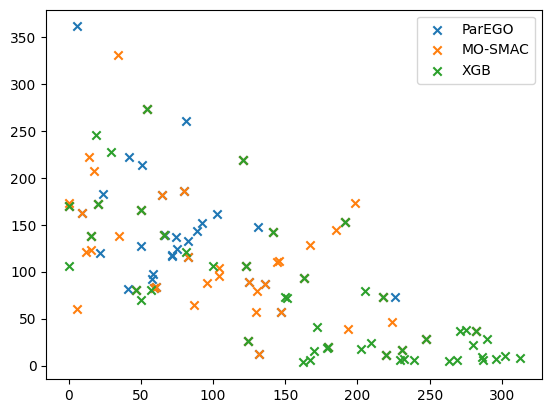

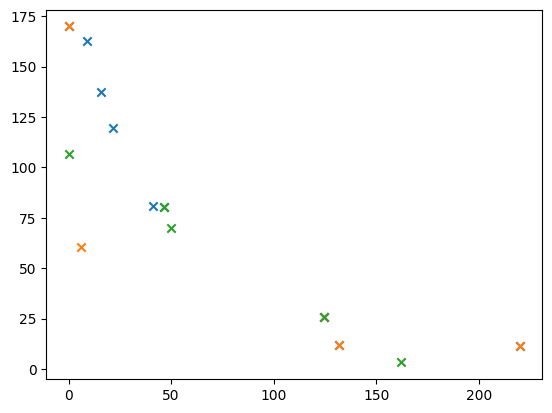

In [11]:
configurators = {
    "ParEGO": smac_pe,
    "MO-SMAC": smac_phvi,
    "XGB": smac_xgb,
}

for configname, configurator in configurators.items():
    # Get all configs
    configs = configurator.runhistory.get_configs_per_budget()
    configurator_costs = [configurator.runhistory.average_cost(i, normalize=False) for i in configs]
    plt.scatter(*list(zip(*configurator_costs)), label=configname, marker="x")
plt.legend()
plt.show()

for configname, configurator in configurators.items():
    # Get incumbent configs
    configs = configurator.runhistory.incumbents
    configurator_costs = [configurator.runhistory.average_cost(i, normalize=False) for i in configs]
    plt.scatter(*list(zip(*configurator_costs)), label=configname, marker="x")
# plt.legend()
# plt.show()